# Goals -

# Backtest Dollar Cost Averaging on SVXY, inverse vol ETF

# Find best conditions to implement strategy

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [293]:
VIX = pd.read_excel('/Users/edwardhuang/Documents/vol_strat.xlsx', sheet_name = 1, index_col = 'Date')

In [294]:
SVXY = pd.read_excel('/Users/edwardhuang/Documents/vol_strat.xlsx', sheet_name = 0, index_col = 'Date')

In [295]:
SVXY.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-10-04,4.93625,5.26250,4.91250,5.26250,5.26250,162400
2011-10-05,5.44125,5.70500,5.43125,5.67375,5.67375,71200
2011-10-06,5.67875,5.79125,5.60000,5.79125,5.79125,44800
2011-10-07,5.89875,5.89875,5.59750,5.83625,5.83625,145600
2011-10-10,5.93750,6.07500,5.92500,6.07500,6.07500,120000


## Find out if there is any significant areas of missing data

In [296]:
VIX[VIX['VIX Close'].isnull()]

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
1991-03-01,NaN,NaN,NaN,NaN
2003-11-27,NaN,NaN,NaN,NaN
2003-12-25,NaN,NaN,NaN,NaN


In [297]:
SVXY[SVXY['Close'].isnull()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


## Join VIX and SVXY data on Date & format table

In [298]:
Total = VIX.join(SVXY, how='inner')

In [299]:
Total.drop(columns = ['VIX Open','VIX High', 'VIX Low', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)

In [300]:
Total.rename(columns={"VIX Close": "VIX Close", "Close": "SVXY Close"}, inplace=True)

In [301]:
Total['Next SVXY'] = Total['SVXY Close'].shift(-1)
Total['Next VIX'] = Total['VIX Close'].shift(-1)

In [302]:
Total['SVXY Delta'] = Total['Next SVXY'] - Total['SVXY Close']
Total['VIX Delta'] = Total['Next VIX'] - Total['VIX Close']

In [303]:
Total['pnl'] = 0

In [304]:
Total.head()

,VIX Close,SVXY Close,Next SVXY,Next VIX,SVXY Delta,VIX Delta,pnl
Date,,,,,,,
2011-10-04,40.82,5.26250,5.67375,37.81,0.41125,-3.01,0
2011-10-05,37.81,5.67375,5.79125,36.27,0.11750,-1.54,0
2011-10-06,36.27,5.79125,5.83625,36.20,0.04500,-0.07,0
2011-10-07,36.20,5.83625,6.07500,33.02,0.23875,-3.18,0
2011-10-10,33.02,6.07500,6.15750,32.86,0.08250,-0.16,0


## Visualize VIX and SVXY as timeseries

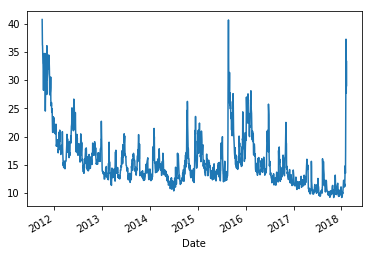

In [305]:
Total['VIX Close'].plot()

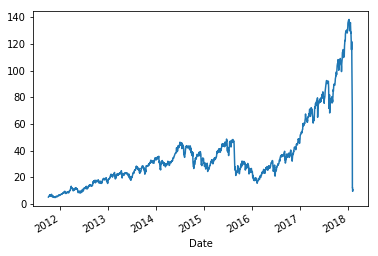

In [306]:
Total['SVXY Close'].plot()

## Create the strategy

In [307]:
def vol_strat(VIX, SVXY, next_SVXY):
    notional = 1000
    shares_bought = notional/SVXY
    pnl = (next_SVXY - SVXY) * shares_bought
    return pnl

In [308]:
Total['pnl'] = np.vectorize(strat)(Total['VIX Close'], Total['SVXY Close'], Total['Next SVXY'])

In [309]:
Total.head()

,VIX Close,SVXY Close,Next SVXY,Next VIX,SVXY Delta,VIX Delta,pnl
Date,,,,,,,
2011-10-04,40.82,5.26250,5.67375,37.81,0.41125,-3.01,78.147268
2011-10-05,37.81,5.67375,5.79125,36.27,0.11750,-1.54,20.709407
2011-10-06,36.27,5.79125,5.83625,36.20,0.04500,-0.07,7.770343
2011-10-07,36.20,5.83625,6.07500,33.02,0.23875,-3.18,40.908117
2011-10-10,33.02,6.07500,6.15750,32.86,0.08250,-0.16,13.580247


## Find PnL if you employed strategy every day vs only when VIX > _?

In [310]:
# If you traded everyday, regardless of VIX level. Rebalance daily.
Total['pnl'].sum()

3022.1866189161929

In [311]:
pnl = Total[Total['VIX Close'] > n]['pnl'].sum()

In [312]:
VIX = 5
VIX_list = []
pnl_list = []
days_list = []

while VIX <= 35:
    pnl = Total[Total['VIX Close'] > VIX]['pnl'].sum()
    days = Total[Total['VIX Close'] > VIX]['pnl'].count()
    VIX_list.append(VIX)
    pnl_list.append(pnl)
    days_list.append(days)
    VIX += 1

In [313]:
# If you traded only when VIX was greater than VIX column in this table. Close trade when VIX is not > than VIX column. Rebalance daily.
VIX_filter = pd.DataFrame(data = list(zip(VIX_list,pnl_list, days_list)), columns = ['VIX','total_pnl','days'])
VIX_filter

,VIX,total_pnl,days
0,5,3022.186619,1598
1,6,3022.186619,1598
2,7,3022.186619,1598
3,8,3022.186619,1598
4,9,3022.186619,1598
5,10,2821.893517,1539
6,11,2834.059216,1445
7,12,2984.616292,1305
8,13,2741.384455,1093
9,14,2302.129741,858


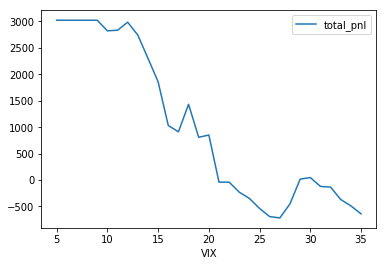

In [314]:
VIX_filter.plot(x = 'VIX', y = 'total_pnl')

Answer: If you employed strategy everyday since beginning of dataset, you would have made 3,022 from 1,000 notional.
This graph actually seems to counter the idea of selling vol spikes, because employing the strat only at higher VIX levels yields less pnl. Probably due to the fact that this is a daily rebalancing strategy.

## Is there a skew for the daily PnL?

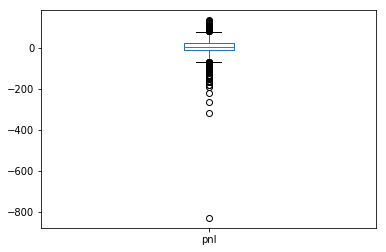

In [315]:
Total['pnl'].plot(kind='box')

## Is there a common denominator for the days when pnl is greater than -2 std?

In [316]:
pnl_std = Total['pnl'].std()
pnl_std

45.47634970098591

In [317]:
# Find number of days when pnl is over -2 Standard Deviations
Total[Total['pnl'] < pnl_std*-2]['pnl'].count()

40

In [318]:
bad_days = Total[Total['pnl'] < pnl_std*-2]

### Still working on above

## Observations

 - Earn highest pnl if you employed strategy every day, rather than selecting days based on VIX level
     - However, this could be misleading due to the fact that VIX has been relatively low since 2016
 - Most PnL falls within one standard deviation (+/- 45)
     - PnL distribution has a fat tail to the negative side. 